So, data in this compretition is very unbalanced... But not in a way you might thing it is.

# Analysis of Key identity groups 

In [1]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
train = pd.read_csv('../input/train.csv')

According to the data description:

> Additionally, a subset of comments have been labelled with a variety of identity attributes, representing the identities that are mentioned in the comment. The columns corresponding to identity attributes are listed below. **Only identities with more than 500 examples in the test set (combined public and private) will be included in the evaluation calculation. These identities are shown in bold.**

In [3]:
# Those are key identities model's bias of which we need to minimize
key_ident = ['male',
             'female',
             'homosexual_gay_or_lesbian',
             'christian',
             'jewish',
             'muslim',
             'black',
             'white',
             'psychiatric_or_mental_illness']

In [4]:
# Subset of data labeled based on mentioned identity of the text
identity_df = train.iloc[:, train.columns != 'parent_id'].dropna()
print('labeled identity samples:', identity_df.shape[0])

labeled identity samples: 405130


Wast majority of labeled comments belong to other groups or don't have any identitites.
Some comments are labeled with multiple identities.

Text(0.5, 1.0, 'number of key identities per comment')

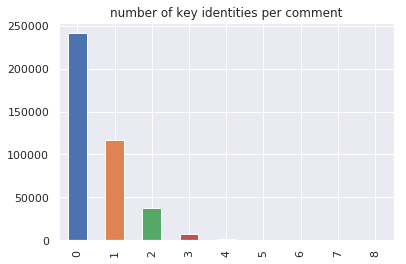

In [5]:
identity_df = train[key_ident + ['comment_text', 'target']].dropna()
for identity in key_ident:
    identity_df[identity] = identity_df[identity]\
                            .apply(lambda x: 1 if x >= 0.5 else 0)
identity_df['sum'] = identity_df[key_ident].sum(axis=1)
identity_df['sum'].value_counts().plot(kind='bar').set_title('number of key identities per comment')

In [6]:
# Somehow this comment managed to mention almost all of them
identity_df[identity_df['sum'] == 8]['comment_text'].values[0].replace('\n', ' ')

'Bigotry must be confronted directly; the sideshow of trying to divide us against each other must be faced and discredited:  Muslim, Christian, Hindu, Jewish, Buddhist, every other religion, Atheist, undecided; "black", "white", brown; male, female, transgender; hetero-, homo-, and pan- sexual; "right", "left", and every other classification used to chop us up into little pieces to be conquered---These must be acknowledged and set aside in the face of our kinship as people inhabiting one planet, and our kinship to every other living thing on this planet.  It\'s that simple.'

Key Identities distribution 

Text(0.5, 1.0, '# of key identity samples')

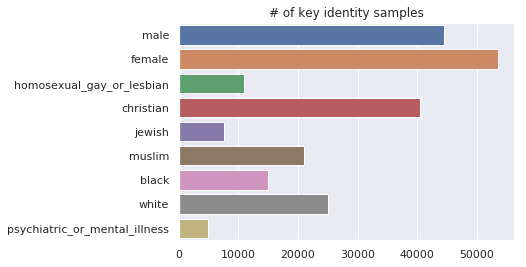

In [7]:
groups_sampels = identity_df[key_ident].sum()
y = groups_sampels.index.values
x = groups_sampels.values
sns.barplot(x=x, y=y).set_title('# of key identity samples')

Text(0.5, 1.0, '# of hatefull comments per group')

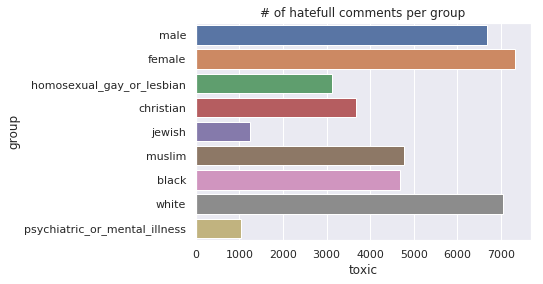

In [8]:
identity_df['target'] = identity_df['target'].apply(lambda x: 1 if x >= 0.5 else 0)
insults = []
for ident in key_ident:
    total = identity_df[(identity_df[ident] == 1) & (identity_df['target'] == 1)].shape[0]
    insults.append(total)
df = pd.DataFrame(data={'toxic':np.array(insults), 'total': x, 'group':y})
sns.barplot(x='toxic', y='group', data=df).set_title('# of hatefull comments per group')

Text(0.5, 1.0, 'toxic to all comments')

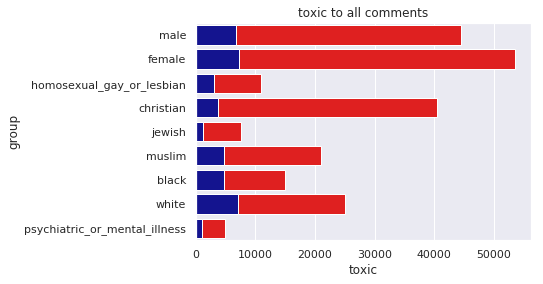

In [9]:
sns.barplot(x='total', y='group', data=df, color = "red")
sns.barplot(x='toxic', y='group', data=df, color = "#0000A3").set_title('toxic to all comments')

# Metrics experementations
-----------------------------------

## Metrics Definition

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from nltk.tokenize import TweetTokenizer
from sklearn import metrics

In [ ]:
# Define bias metrics, then evaluate our new model for bias using the validation set predictions
# https://www.kaggle.com/dborkan/benchmark-kernel
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples 
        and the background positive examples.
    """
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples 
        and the background negative examples.
    """
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups 
      and one model.
    """
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, 
                                                    subgroup, 
                                                    label_col, 
                                                    model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, 
                                            subgroup, 
                                            label_col, 
                                            model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, 
                                            subgroup, 
                                            label_col, 
                                            model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)
#-----------------------------------------------------------------------------------------------------
# Calculate the final score

def calculate_overall_auc(df, oof_name):
    true_labels = df['target']
    predicted_labels = df[oof_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)


In [ ]:
# adding preprocessing from this kernel: https://www.kaggle.com/taindow/simple-cudnngru-python-keras
punct_mapping = {"_":" ", "`":" "}
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
def clean_special_chars(text, punct, mapping):
    for p in mapping:
        text = text.replace(p, mapping[p])    
    for p in punct:
        text = text.replace(p, f' {p} ')     
    return text
identity_df['comment_text'] = identity_df['comment_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))
identity_df['comment_text'] = identity_df['comment_text'].apply(lambda x: clean_special_chars(x, punct, punct_mapping))

## Actual experiments

We will use Logistic Regression as our model.
We will use only subset of data with known identities. And also will track only one subgroup in oreder to make it simple.

### 1. Effect of positive data mentioning identity

In [ ]:
# Our Model and predict function
# Taken from https://www.kaggle.com/artgor/toxicity-eda-model-interpretation-and-more
logreg = LogisticRegression()
oof_name = 'predicted_target'

def fit_log_reg(X_train, y_train, valid_df):
    logreg.fit(X_train, y_train)
    valid_df[oof_name] = logreg.predict_proba(valid_vectorized)[:, 1]
    return valid_df

In [ ]:
train_df, valid_df = train_test_split(identity_df, test_size=0.2)
y_valid = valid_df['target']
for col in key_ident + ['target']:
    valid_df[col] = np.where(valid_df[col] >= 0.5, True, False)

In [ ]:
%%time
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), 
                             tokenizer=tokenizer.tokenize, 
                             max_features=30000)
vectorizer.fit(identity_df['comment_text'].values)
valid_vectorized = vectorizer.transform(valid_df['comment_text'].values)

In [ ]:
# Select only examples with toxic comments mentioning identity
women_negative = train_df[~((train_df['female'] == True) & 
                            (train_df['target'] == False))]
y_train = women_negative['target']
train_vectorized = vectorizer.transform(women_negative['comment_text'].values)

#### Metrics breakdown to help interpret results

**subgroup_auc**: Here, we restrict the data set to only the examples that mention the specific identity subgroup.* A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.*

**bpsn_auc**: Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not,* likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.*

**bnsp_auc**: Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not,* likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.*

In [ ]:
track_column = ['female']
valid_df = fit_log_reg(train_vectorized, y_train, valid_df)
pretty_cols = ['subgroup', 'subgroup_auc', 'bpsn_auc', 'bnsp_auc', 'subgroup_size']

def get_scores(valid_df, track_column, oof_name):
    bias_metrics_df = compute_bias_metrics_for_model(valid_df, 
                                                     track_column, 
                                                     oof_name, 'target')
    final_metric = get_final_metric(bias_metrics_df, 
                                    calculate_overall_auc(valid_df, oof_name))
    
    return bias_metrics_df[pretty_cols], final_metric

metrics_df, final_metric = get_scores(valid_df, track_column, oof_name)
roc_auc = metrics.roc_auc_score(valid_df[track_column], valid_df['predicted_target'])
print('bias score:', final_metric)
print('classic roc_auc_score:', roc_auc)
metrics_df

**Here we semulated the bias problem noticed by the jigsaw teem: the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.(namely low bpsn_auc score)
Their explanation of the problem:**

**Why are these errors happening?**

> Identity terms for more frequently targeted groups (e.g. words like “black”, “muslim”, “feminist”, “woman”, “gay” etc) often have higher scores because comments about those groups are over-represented in abusive and toxic comments. Unfortunately, that means that the data we used to train Perspective exhibits that same trend: the names of targeted groups appear far more often in abusive comments. For example, in many forums unfortunately it’s common to use the word “gay” as an insult, or for someone to attack a commenter for being gay, but it is much rarer for the word gay to appear in a positive, affirming statements (e.g. “I am a proud gay man”). When the training data used to train machine learning models contain these comments, ML models adopt the biases that exist in these underlying distributions, picking up negative connotations as they go. When there’s insufficient diversity in the data, the models can over-generalize and make these kinds of errors.

[Full article](http://medium.com/the-false-positive/unintended-bias-and-names-of-frequently-targeted-groups-8e0b81f80a23)

In [ ]:
# Now select only examples without toxic coments mentioning the identity
women_pos = train_df[((train_df['female'] == True) & (train_df['target'] == False))]
# We will inject this data in 10 steps
n = 10
split = women_pos.shape[0]//n
dfs = [women_pos.iloc[i*split:(i+1)*split].copy() for i in range(n)]

In [ ]:
# Injecting positive comments, mentioning identity and retraining model each time
metrics_dfs = [metrics_df]
final_metrics = [(final_metric, roc_auc)]
for i in range(n):
    women_negative = pd.concat([women_negative, dfs[i]])
    train_vectorized = vectorizer.transform(women_negative['comment_text'].values)
    y_train = women_negative['target']
    valid_df = fit_log_reg(train_vectorized, y_train, valid_df)
    metrics_df, final_metric = get_scores(valid_df, track_column, oof_name)
    roc_auc = metrics.roc_auc_score(valid_df[track_column], valid_df['predicted_target'])
    metrics_dfs.append(metrics_df)
    final_metrics.append((final_metric, roc_auc))
    print(final_metric, roc_auc)
    print(metrics_df)


In [ ]:
graf = pd.concat(metrics_dfs)
graf['data injection steps'] = np.arange(len(metrics_dfs))
graf.set_index(['data injection steps'], inplace = True)
graf[['subgroup_auc', 'bpsn_auc', 'bnsp_auc']].plot()

In [ ]:
plt.plot(*zip(*final_metrics))
plt.xlabel('Competition metrics')
plt.ylabel('Standard roc_auc')

So, there is lot to unpack here. Let's go step by step. First the change in **bpsn_auc** is predictably going up. We add more and more sentiment positive comments mentioning identity, model is forced to accomodate and stop discriminate "mindlessly". But side effect of that is falling **bnsp_auc**. The model now tries to find what separates normal comments from toxic with the same identity, that leeds to higher rate of false negative classification. **bnsp_auc** is falling because model is more "hessitant" to classify positive examples as such. That dinamics is seen in **subgroup_auc** score. It first rises because model begins to be less bias, but then slows down as model struggles to find a good balance between not creating false negatives and reducing biase simultaneously, as amount of data with positive sentiment grows.

What even more interesting is, that area under roc curve and competition metrics might not be positively correlated. It maight be connected to increase in data complexity, where similar words have different meaning making the task of distinguishing between classes way harder. Since it becomes harder to find a good threashold to separate the data roc_aur falls. But our bias metrics go up, for the reasons described above. At the end of the day or goal is to create an unbiased classifier, not accurate one.

Couple of conclusions:
1. Use of roc_auc metrics in this competition is questionable decision. Relationships between it and biase are not that simple.
2. We can dramaticly reduce biase just by adding more data, without any ml hacks. The question is just how much? it's defenitely not 50/50 ratio. My best guess would be adding as long as competition metrics grows.

![](http://imgur.com/eozrQwR.jpg)

The image is taken from [starting kernal](http://www.kaggle.com/dborkan/benchmark-kernel). Judging by the resaults it seems there is plenty of room to add more data with positive sentiment. And I have to admit that it's a very counterintuitive statement, that we don't have enough postive sentiment data. I might be wrong, so take that with a grain of salt. 

### 2. Effect of unrelated to identity comments
-----------------------------
Big advantage of data given in that competition is amount of positive identity comments. Unlike the first jigsaw competition we are dealing with comments on different political events. Thankfully those comments are full of both positive sentiment and negative sentiment samples. But what about nonrelated to any key identity comments? What role do they play in bias estimate?

In [ ]:
# Select only examples with toxic comments related to key identities
related = train_df[~(train_df['sum'] == 0)]
y_train = related['target']
train_vectorized = vectorizer.transform(related['comment_text'].values)

In [ ]:
valid_df = fit_log_reg(train_vectorized, y_train, valid_df)
metrics_df, final_metric = get_scores(valid_df, track_column, oof_name)
roc_auc = metrics.roc_auc_score(valid_df[track_column], valid_df['predicted_target'])
print('bias score:', final_metric)
print('classic roc_auc_score:', roc_auc)
metrics_df

As expected it damaged roc_auc score, but bias isn't strongly affected. It went down slightly. May be some data missclassified, or what is more likely unrelated toxic comments help the model to figure out when the comment is toxic in general. 

In [ ]:
# Now select only examples of unrelated to key identity comments
unrelated = train_df[(train_df['sum'] == 0)]
# We will inject this data in 10 steps
n = 10
split = unrelated.shape[0]//n
dfs = [unrelated.iloc[i*split:(i+1)*split].copy() for i in range(n)]

In [ ]:
# Injecting unrelated comments
metrics_dfs = [metrics_df]
final_metrics = [(final_metric, roc_auc)]
for i in range(n):
    related = pd.concat([related, dfs[i]])
    train_vectorized = vectorizer.transform(related['comment_text'].values)
    y_train = related['target']
    valid_df = fit_log_reg(train_vectorized, y_train, valid_df)
    metrics_df, final_metric = get_scores(valid_df, track_column, oof_name)
    roc_auc = metrics.roc_auc_score(valid_df[track_column], valid_df['predicted_target'])
    metrics_dfs.append(metrics_df)
    final_metrics.append((final_metric, roc_auc))
    print(final_metric, roc_auc)
    print(metrics_df)

In [ ]:
graf = pd.concat(metrics_dfs)
graf['data injection steps'] = np.arange(len(metrics_dfs))
graf.set_index(['data injection steps'], inplace = True)
graf[['subgroup_auc', 'bpsn_auc', 'bnsp_auc']].plot()

In [ ]:
plt.plot(*zip(*final_metrics))
plt.xlabel('Competition metrics')
plt.ylabel('Standard roc_auc')

Again, here is my interpretation. I can be wrong of course. Here is the opposite picture **bnsp_auc**  grows and **bpsn_auc** slowly decreases. Probably more unrelated samples give model a better feeling on what is considered to be toxic, so it becomes less "hesitant" to classify toxic comments with identity as positive. Strong correlation of identity meaningfull words with in general toxic words may lead to more false positives and lower **bpsn_auc** score. But that decrease is offset by grows in **bnsp_auc** so the final metrics is slowly growing.

In these case classic roc_auc score has positive correlation with competition metrics. Additional data doesn't have complicated cases where similar words might be used negatively and positively. So, it doesn't introduce additional complexity to the problem, and does not affect negatively model's ability to separate classes.

Some conclusions:
1. Unrelated data has a positive overall effect on bias and accuracy and should be deffinately used if there is no alternative.
2. Though unrelated data has a positive effect it comes with a heavy price, in order to increase competition metrics on about 2% requred 2.5 increase in amount of data. 324096 vs just 130896 samples. 

Our goal is to reduce bias for many identity groups, not just one. In this case data unrelated to any of the group adds a lot to computational cost and not so much to overall perfomance. If that data is replaced with identity related data it may significantly reduce bias for one group, and simultenuasly have a positive effect on perfomance for other groups, though not as strong. At the same time we preserve the same level of computational cost.

Please keep in mind, that all of that is just my speculations. I might be reading data incorrectly, or there is bug in code. The main idea of the kernel is to get a better intuition on the competiton metrics. If you've managet to read till the end, here is a meme to cheer you up.

![](https://imgur.com/ROf6Iss.jpg)